In [1]:
#in case you are using google colab
!pip install yt
!pip install f90nml

     |████████████████████████████████| 61.5 MB 1.3 MB/s 
     |████████████████████████████████| 98 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 40.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 62 kB 795 kB/s 
  Created wheel for f90nml: filename=f90nml-1.3.1-py2.py3-none-any.whl size=30588 sha256=4338725eb9264b41241a8ab61df5a01d15270d47d941aff49a17b5dbb7a8ee8d
  Stored in directory: /root/.cache/pip/wheels/32/a9/03/6560987ac8a7c1010c9693dea20772559cec9f34230475c835
Successfully built f90nml


In [3]:
import yt
import f90nml
import pandas
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from matplotlib.pyplot import cm

In [4]:
def velocity(field, data):
  return data['m2'].to_ndarray() / data["rho"].to_ndarray()

# Links about the Fields

https://yt-project.org/doc/reference/field_list.html#field-list

https://yt-project.org/doc/analyzing/fields.html#known-field-types

https://education.molssi.org/python-data-analysis/03-data-fitting/index.html

# Data processing

In [5]:
#datafiles is the path of your files

def data_processing(a,b, datafiles):
  #a: give here your start snapshot
  #b: give here your last snapshot
  # Time array depends on time interval between snapshots: in the case 0.5s
  time = [i for i in np.arange(a/2,b/2,0.5)]
  data = []

  for i in range(a,b): #loop over the snapshots
    ds = yt.load(datafiles % i)
    ds.add_field(('gas', "y_velocity"), function=velocity ,units='', sampling_type='cell')
    all = ds.covering_grid(level=3, left_edge=[0, 0.0, 0.0], dims=ds.domain_dimensions)

    v = all['gas', 'y_velocity']
    v = np.squeeze(v,axis=2) 

    ft = np.fft.rfft(v, axis=0) #Fourier transform of the velocity
    
    mode_data = []
    for m in range(1,17): #The 0th is the average, we don't look at that
      test = abs(ft[m][120])  # Here we look at the middle. we have a size of 240, so 120 is the centrum of the snapshot
      mode_data.append(test)
    data.append(mode_data)  #we have a 2d array, where the columns represent the growths of each mode

  # make it an numpy array
  growth_data = np.array(data) 
  growth_data = growth_data.transpose() # now we have in each row the growth of a mode  
  return growth_data, time

In [8]:
#### All of our datasets #####
## MAKE SURE YOU CHANGE THE PATH TO YOURS" #####
data_B1, time_B1 = data_processing(30,51,"16_modes_B_0.006%04d.dat")
data_B2, time_B2 = data_processing(30,51,"16_modes_B_0.007%04d.dat")
data_B3, time_B3 = data_processing(30,59,"16_modes_B_0.008%04d.dat")
data_B4, time_B4 = data_processing(30,54,"16_modes_B_0.009%04d.dat")

data_B0, time_B0 = data_processing(30,59,"16_modes_per_6%04d.dat")
data_B5, time_B5 = data_processing(30,50,"6_0.005/a%04d.dat")
data_B6, time_B6 = data_processing(30,51,"6_0.0085/a%04d.dat")
data_B7, time_B7 = data_processing(30,61,"/6_0.01/a%04d.dat")

yt : [INFO     ] 2021-12-22 15:15:13,781 Parameters: current_time              = 15.0
yt : [INFO     ] 2021-12-22 15:15:13,783 Parameters: domain_dimensions         = [192 192   1]
yt : [INFO     ] 2021-12-22 15:15:13,788 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-12-22 15:15:13,791 Parameters: domain_right_edge         = [4. 4. 1.]
yt : [INFO     ] 2021-12-22 15:15:13,794 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2021-12-22 15:15:13,938 Using full MHD energy for thermal pressure.
yt : [INFO     ] 2021-12-22 15:15:16,654 Parameters: current_time              = 15.5
yt : [INFO     ] 2021-12-22 15:15:16,659 Parameters: domain_dimensions         = [192 192   1]
yt : [INFO     ] 2021-12-22 15:15:16,662 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-12-22 15:15:16,665 Parameters: domain_right_edge         = [4. 4. 1.]
yt : [INFO     ] 2021-12-22 15:15:16,668 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 20

# Plots every mode for 1 value of B

In [25]:
#This plots every mode for 1 value of B
def plot_growths(timeX, dataX, B):
  fig = plt.figure(figsize=(12,7))
  ax = plt.subplot(111)
  #making of the plot
  colors = cm.rainbow(np.linspace(0, 1, len(dataX)))
  mode = np.arange(1,len(dataX)+1,1)

  for i, mode_growth in enumerate(dataX):
    ax.plot(timeX,dataX[i], c = colors[i], label = "mode " + str(mode[i]))

  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.xlabel("Time [s]")
  plt.ylabel("Amplitude")
  plt.title("growth of the modes with B={}".format(B))
  plt.savefig("All_Modes_B={}.png".format(B), bbox_inches='tight')
  plt.show()

# Calculation of the growth rates

In [10]:
#This is the block where the growth rates are measured of each mode, by fitting and exponential to them

#log fit!
from scipy.optimize import curve_fit
import numpy as np
import math
def exponential(x,A,B):
  y = A * np.exp(B*x)
  return y

def fit(time_data, growth_data):
  rate_off_growths = []
  for i, mode_growth in enumerate(growth_data):
    parameters, covariance = curve_fit(exponential, time_data, mode_growth)
    # fit_A = parameters[0]
    fit_B = parameters[1]
    rate_off_growths.append(fit_B)

  #   fit_y = [exponential(step, fit_A, fit_B) for step in time ]
  # plt.plot(time, data, 'o', label='data')
  # plt.plot(time, fit_y, '-', label='fit')
  # plt.legend()

  return rate_off_growths

# Comparison of the growths

In [32]:
#A comparison is made here by plotting the same mode for different values of B

def compare(chosen_mode):
  #making of the plot:
  colors = cm.rainbow(np.linspace(0, 1, 8))
  fig = plt.figure(figsize=(8,5))
  ax = plt.subplot(111)
  ax.plot(time_B0,data_B0[i], c = colors[0], label = "B= " + "0")
  ax.plot(time_B1,data_B1[i], c = colors[1], label = "B= " + "0.006")
  ax.plot(time_B2,data_B2[i], c = colors[2], label = "B= " + "0.007")
  ax.plot(time_B3,data_B3[i], c = colors[3], label = "B= " + "0.008")
  ax.plot(time_B4,data_B4[i], c = colors[4], label = "B= " + "0.009")
  ax.plot(time_B5,data_B5[i], c = colors[5], label = "B= " + "0.005")
  ax.plot(time_B6,data_B6[i], c = colors[6], label = "B= " + "0.0085")
  ax.plot(time_B7,data_B7[i], c = colors[7], label = "B= " + "0.01")

  #plot appearance
  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.xlabel("Time [s]")
  plt.ylabel("Amplitude")
  plt.title("Comparison of the growth for mode {}".format(i))
  plt.savefig("mode{}_All_B_Values.png".format(chosen_mode), bbox_inches='tight')
  plt.show()

# **The plots.**

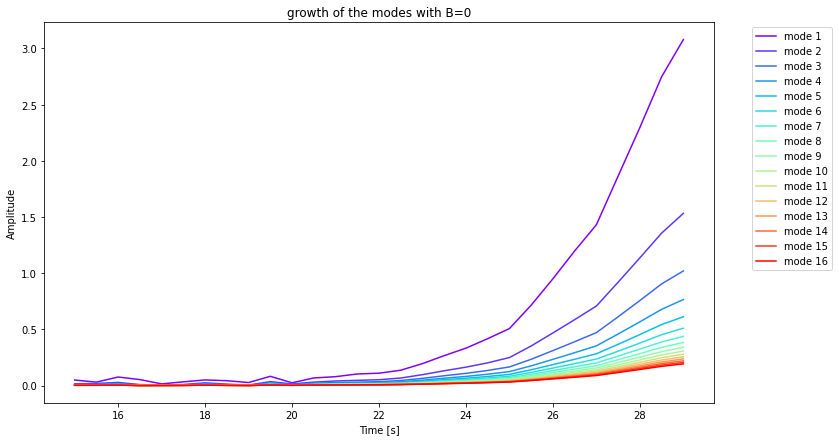

In [26]:
plot_growths(time_B0,data_B0,0)
rate_of_growths_B0= fit(time_B0,data_B0)

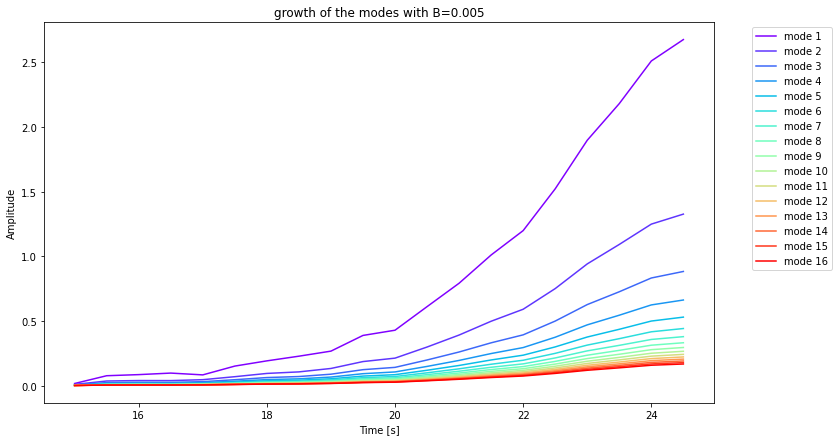

In [27]:
plot_growths(time_B5,data_B5,0.005)
rate_of_growths_B5= fit(time_B5,data_B5)
rate_of_growths_B5_norm = np.array(rate_of_growths_B5)/ np.array(rate_of_growths_B0)

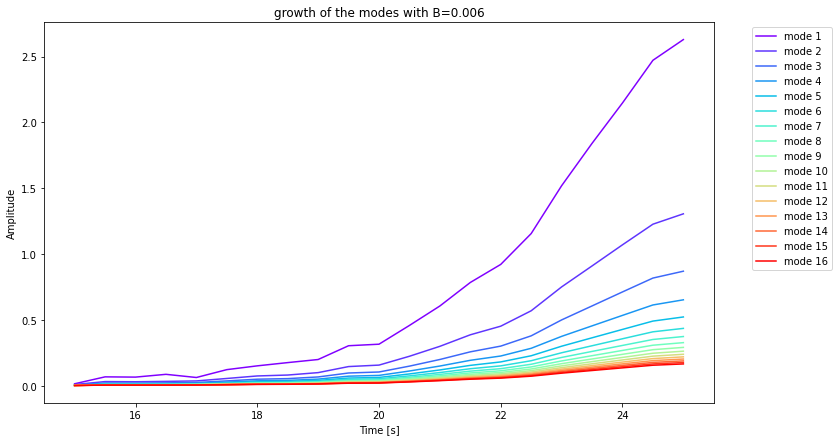

In [28]:
plot_growths(time_B1,data_B1,0.006)
rate_of_growths_B1= fit(time_B1,data_B1)
rate_of_growths_B1_norm = np.array(rate_of_growths_B1)/ np.array(rate_of_growths_B0)

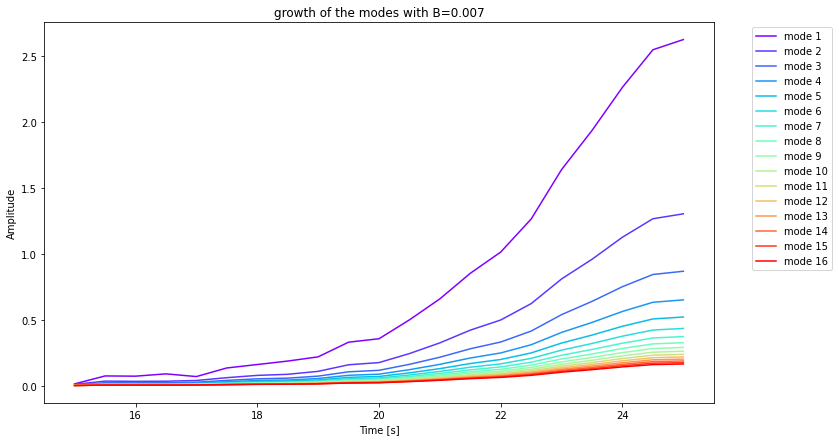

In [29]:
plot_growths(time_B2,data_B2,0.007)
rate_of_growths_B2= fit(time_B2,data_B2)
rate_of_growths_B2_norm = np.array(rate_of_growths_B2)/ np.array(rate_of_growths_B0)

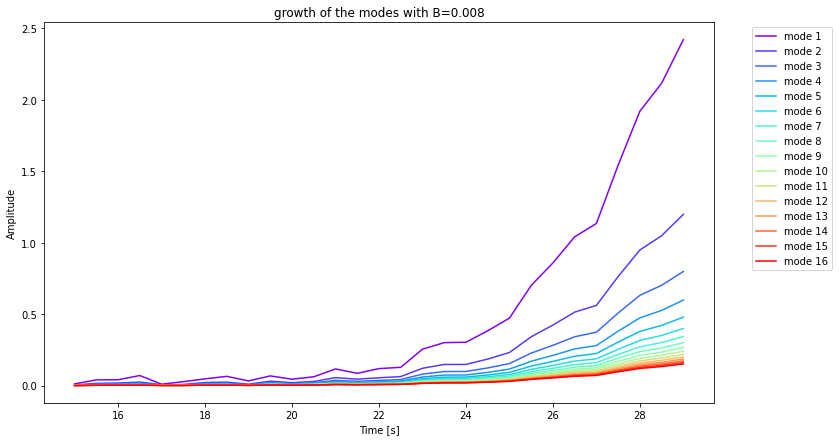

In [30]:
plot_growths(time_B3,data_B3,0.008)
rate_of_growths_B3= fit(time_B3,data_B3)
rate_of_growths_B3_norm = np.array(rate_of_growths_B3)/ np.array(rate_of_growths_B0)

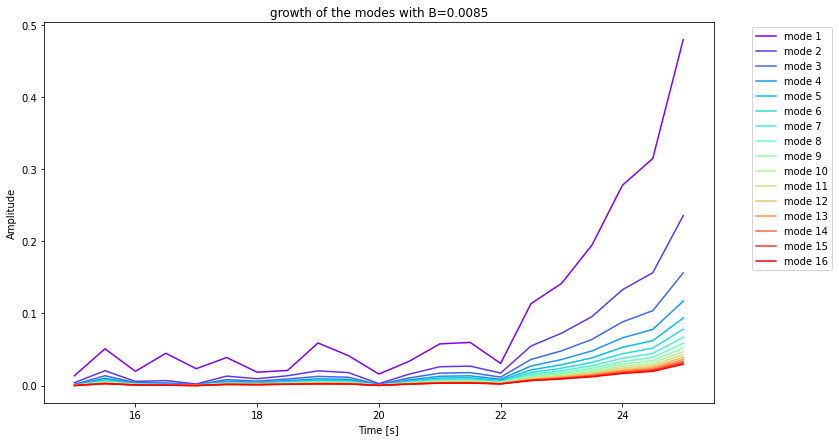

In [31]:
plot_growths(time_B6,data_B6,0.0085)
rate_of_growths_B6= fit(time_B6,data_B6)
rate_of_growths_B6_norm = np.array(rate_of_growths_B6)/ np.array(rate_of_growths_B0)

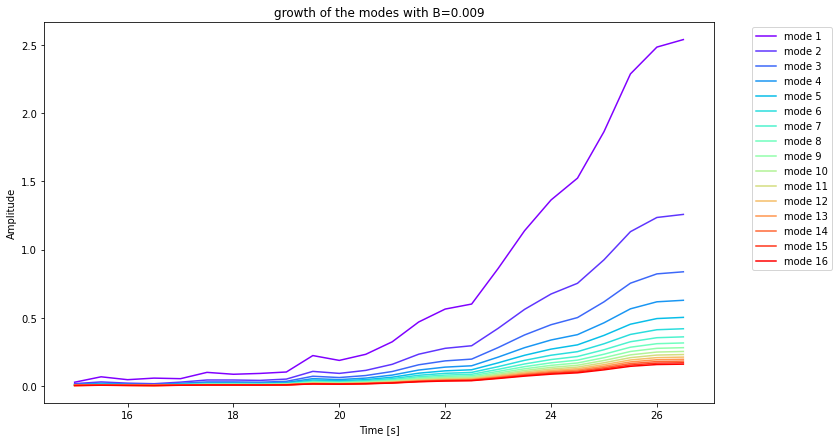

In [18]:
plot_growths(time_B4,data_B4,0.009)
rate_of_growths_B4=fit(time_B4,data_B4)
rate_of_growths_B4_norm = np.array(rate_of_growths_B4)/ np.array(rate_of_growths_B0)

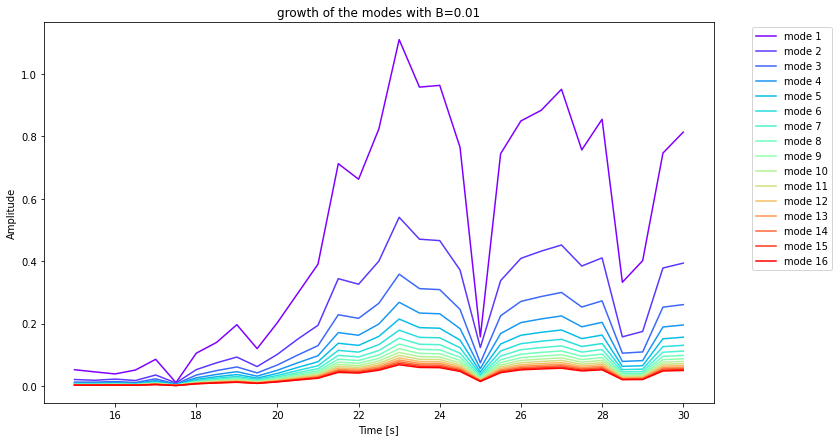

In [19]:
plot_growths(time_B7,data_B7,0.01)
rate_of_growths_B7= fit(time_B7,data_B7)
rate_of_growths_B7_norm = np.array(rate_of_growths_B7)/ np.array(rate_of_growths_B0)

#Evolution of growth rate with increasing value of B, normalized on B = 0

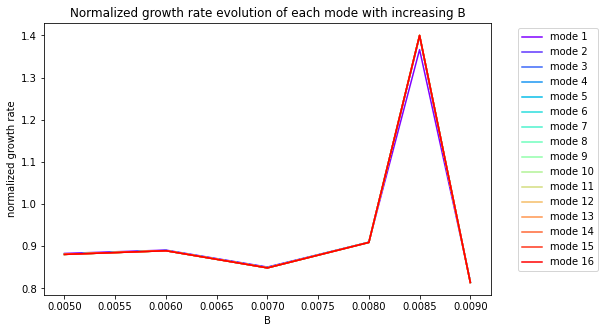

In [34]:

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)
colors = cm.rainbow(np.linspace(0, 1, len(rate_of_growths_B0)))

for i in range(len(rate_of_growths_B0)): #16 modes
  rates = [rate_of_growths_B5_norm[i],rate_of_growths_B1_norm[i], rate_of_growths_B2_norm[i], rate_of_growths_B3_norm[i],rate_of_growths_B6_norm[i],rate_of_growths_B4_norm[i]]
  ax.plot([0.005,0.006,0.007,0.008,0.0085,0.009],rates, c = colors[i], label = "mode {}".format(i+1))

  #plot appearance
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("B")
plt.ylabel("normalized growth rate")
plt.title("Normalized growth rate evolution of each mode with increasing B")
plt.savefig("Evolution_growth_rate.png", bbox_inches='tight')
plt.show()

# The 16 plots of comparison

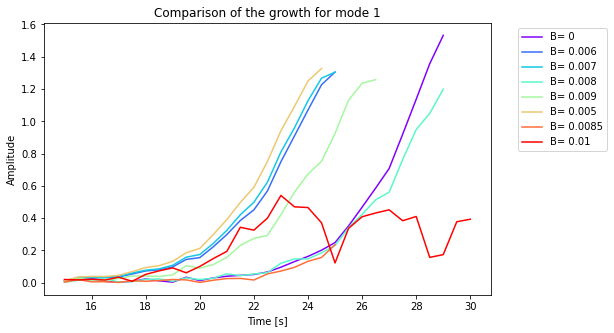

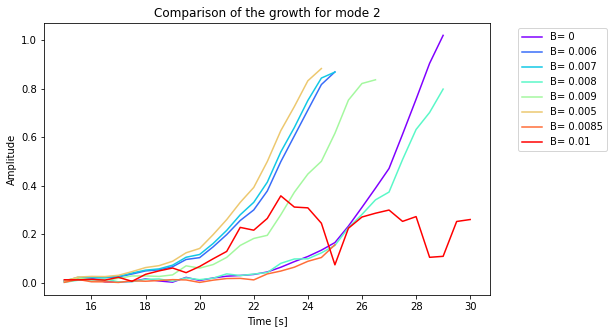

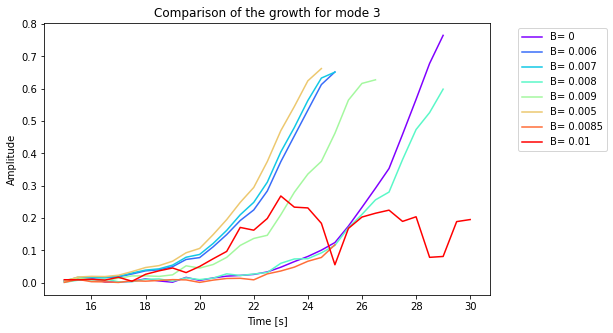

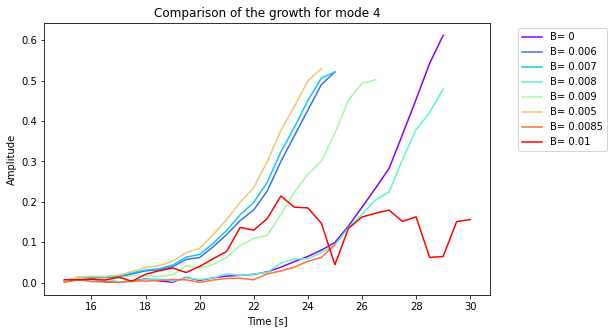

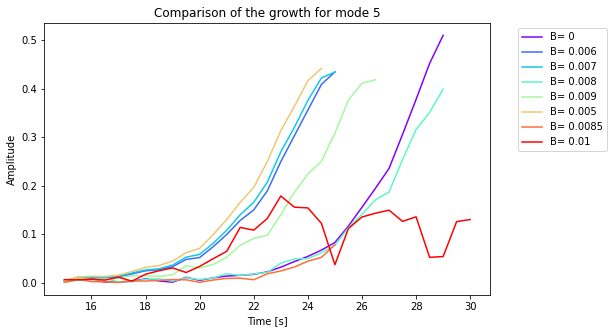

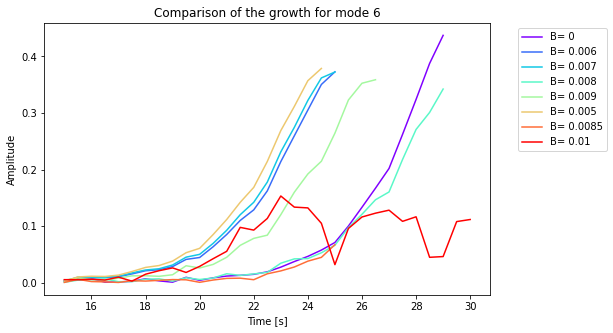

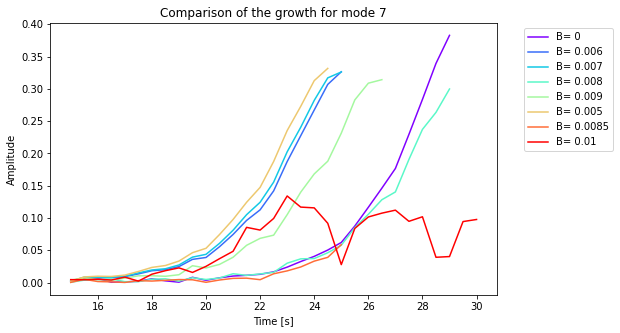

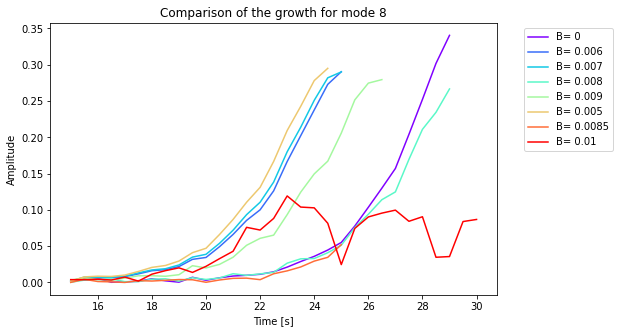

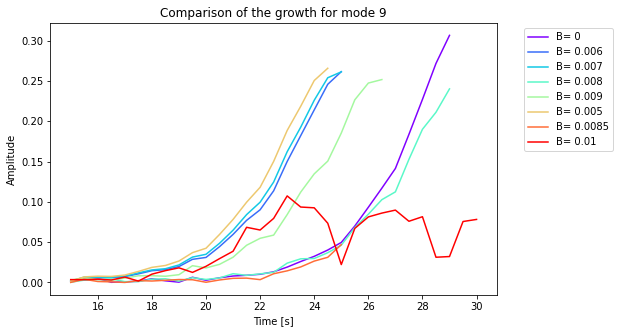

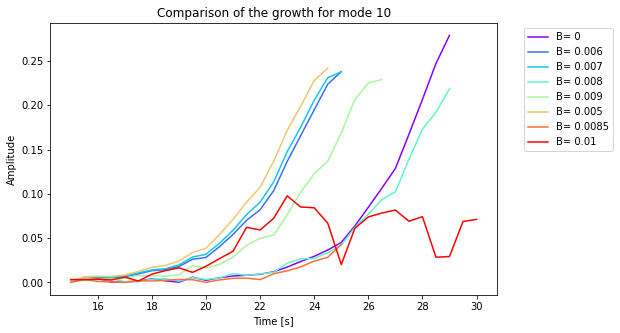

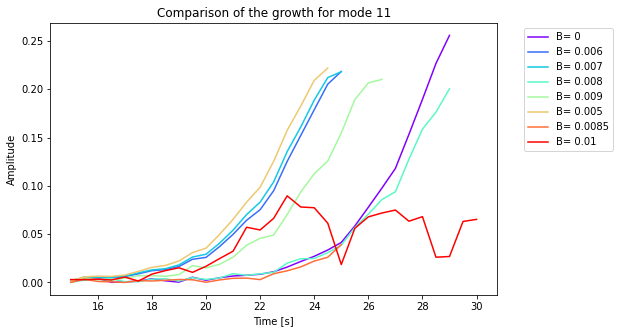

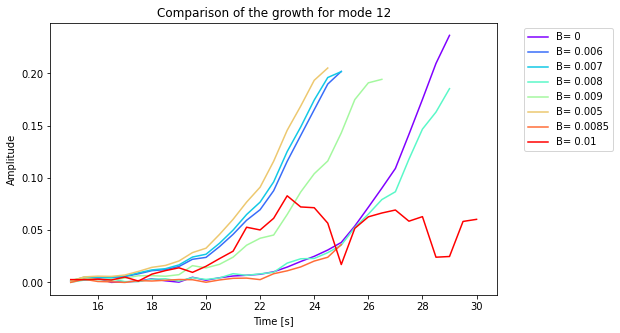

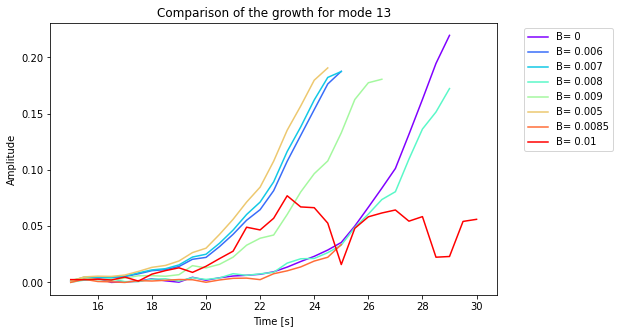

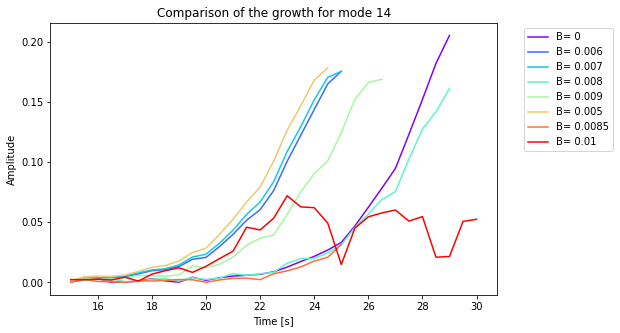

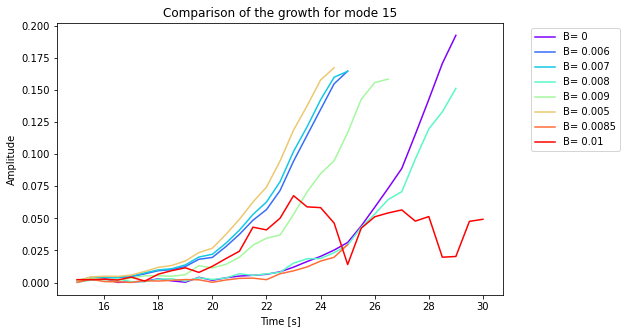

In [35]:
for i in range(1,len(data_B3)):
  compare(i)